In [1]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                        fname='flower_photos', untar=True)


In [3]:
data_root = pathlib.Path(data_root_orig)
print(data_root)


/home/ma/.keras/datasets/flower_photos


In [4]:
for item in data_root.iterdir():
    print(item)


/home/ma/.keras/datasets/flower_photos/LICENSE.txt
/home/ma/.keras/datasets/flower_photos/roses
/home/ma/.keras/datasets/flower_photos/daisy
/home/ma/.keras/datasets/flower_photos/dandelion
/home/ma/.keras/datasets/flower_photos/tulips
/home/ma/.keras/datasets/flower_photos/sunflowers


In [5]:
import random

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)
image_count = len(all_image_paths)


In [6]:
all_image_paths[:10]

['/home/ma/.keras/datasets/flower_photos/sunflowers/15066430311_fb57fa92b0_m.jpg',
 '/home/ma/.keras/datasets/flower_photos/dandelion/17482158576_86c5ebc2f8.jpg',
 '/home/ma/.keras/datasets/flower_photos/tulips/4522153453_06437ca3af_m.jpg',
 '/home/ma/.keras/datasets/flower_photos/tulips/17202535346_ab828e779b.jpg',
 '/home/ma/.keras/datasets/flower_photos/dandelion/2473862606_291ae74885.jpg',
 '/home/ma/.keras/datasets/flower_photos/daisy/16360180712_b72695928c_n.jpg',
 '/home/ma/.keras/datasets/flower_photos/sunflowers/235651658_a7b3e7cbdd.jpg',
 '/home/ma/.keras/datasets/flower_photos/sunflowers/2759796022_55bd47bfa2_n.jpg',
 '/home/ma/.keras/datasets/flower_photos/sunflowers/969913643_9d5cd2fe45_m.jpg',
 '/home/ma/.keras/datasets/flower_photos/daisy/7133935763_82b17c8e1b_n.jpg']

In [7]:
import os

attributions = (data_root/"LICENSE.txt").open(encoding='utf-8').readlines()[4:]
attributions = [line.split(' CC-BY') for line in attributions]
attributions = dict(attributions)


In [8]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + '-'.join(attributions[str(image_rel)].split(' - ' )[:-1])


In [9]:
caption_image(all_image_paths[0])

'Image (CC BY 2.0)  by Mike Mozart'

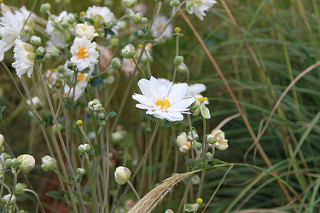

Image (CC BY 2.0)  by Marco Assini



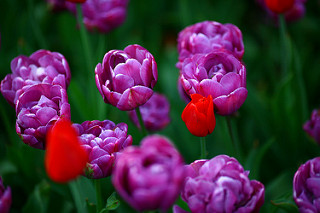

Image (CC BY 2.0)  by *highlimitzz



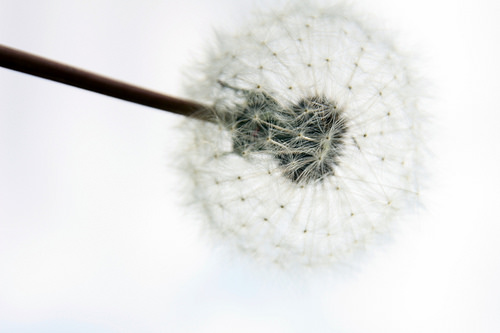

Image (CC BY 2.0)  by Martin Fisch



In [10]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(caption_image(image_path))
    print()


In [11]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())


In [12]:
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [13]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))


In [14]:
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [15]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])


First 10 labels indices:  [3, 1, 4, 4, 1, 0, 3, 3, 3, 0]


In [16]:
img_path = all_image_paths[0]


In [17]:
img_path

'/home/ma/.keras/datasets/flower_photos/sunflowers/15066430311_fb57fa92b0_m.jpg'

In [18]:
img_raw = tf.io.read_file(image_path)
print(repr(img_raw)[:100]+'...')


<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x...


In [19]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)


(333, 500, 3)
<dtype: 'uint8'>


In [20]:
img_final = tf.image.resize(img_tensor, [192,192])
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())


(192, 192, 3)
0.0
1.0


In [21]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [192,192])
    image /= 255.0

    return image

    
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)


Text(0.5, 1.0, 'Sunflowers')

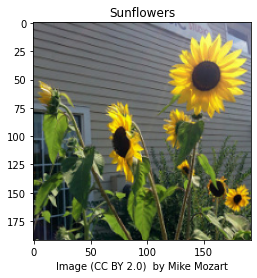

In [22]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.xlabel(caption_image(image_path))
plt.title(label_names[label].title())


In [23]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)


In [24]:
path_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [25]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)


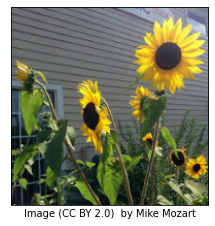

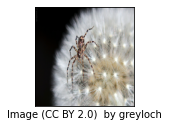

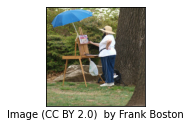

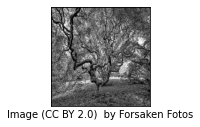

In [26]:
plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(caption_image(all_image_paths[n]))
    plt.show()


In [27]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

for label in label_ds.take(10):
    print(label_names[label])


sunflowers
dandelion
tulips
tulips
dandelion
daisy
sunflowers
sunflowers
sunflowers
daisy


In [28]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)


<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [29]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds


<MapDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int32)>

In [30]:
BATCH_SIZE = 32

ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds


<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [31]:
ds = image_label_ds.apply(
    tf.data.experimental.shuffle_and_repeat(buffer_size=(image_count)))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds


Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int32)>

In [32]:
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192,192,3), include_top=False)
mobile_net.trainable=False


9412608/9406464 [==============================] - 1s 0us/step


In [33]:
def change_range(image, label):
    return 2*image-1, label

keras_ds = ds.map(change_range)


In [34]:
image_batch, label_batch = next(iter(keras_ds))


In [35]:
feature_map_batch = mobile_net(image_batch)


In [36]:
print(feature_map_batch.shape)

(32, 6, 6, 1280)


In [37]:
model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dense(len(label_names))
])


In [38]:
logit_batch = model(image_batch).numpy()
print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())

print()
print("Shape:", logit_batch.shape)


min logit: -1.4543158
max logit: 2.3223104

Shape: (32, 5)


In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [47]:
len(model.trainable_variables)

2

In [48]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [49]:
steps_per_epoch = tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

115.0

In [50]:
model.fit(ds, epochs=1, steps_per_epoch=3)


3/3 [==============================] - 0s 53ms/step - loss: 6.0903 - accuracy: 0.1562
